## Deep MMD - GAN with Celeb-A dataset


In [1]:
%matplotlib inline

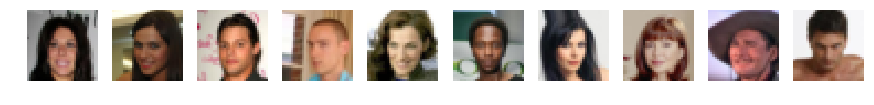

In [2]:
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms

from utils import GeneratorNet, DiscriminatorNet, show_images


class options:
    cuda = True
    batch_size = 128
    image_size = 32
    n_filters = 100
    
transform = transforms.Compose([
    transforms.Scale( options.image_size ),
    transforms.CenterCrop(options.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./datasets/celeb-splitted/', transform=transform), 
    batch_size=options.batch_size, shuffle=True, num_workers=1)


for x, _ in dataloader:
    show_images(x)
    break

0 0 1583 13.353960037231445


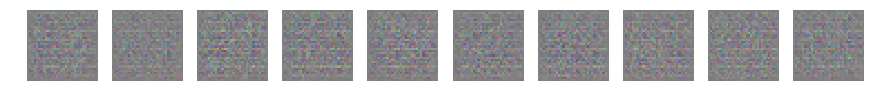

0 700 1583 8.21893310546875


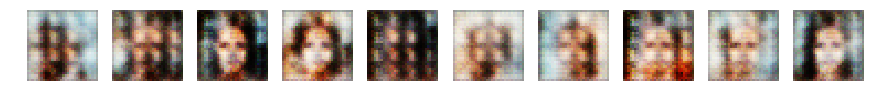

0 1400 1583 4.9806318283081055


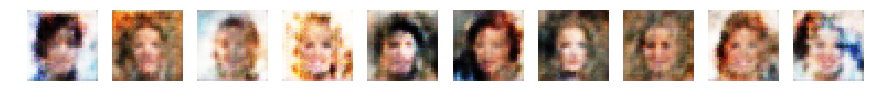

1 0 1583 7.362856864929199


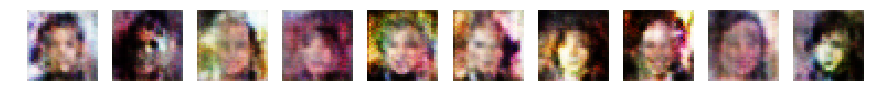

1 700 1583 6.420285701751709


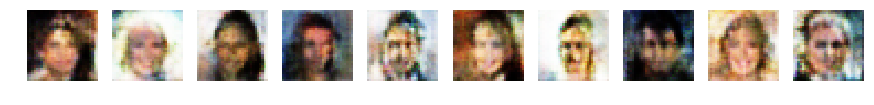

1 1400 1583 7.721991062164307


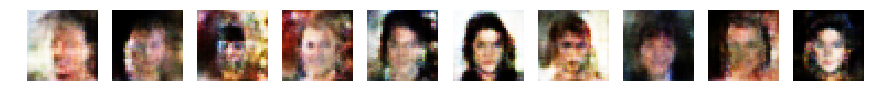

2 0 1583 8.889805793762207


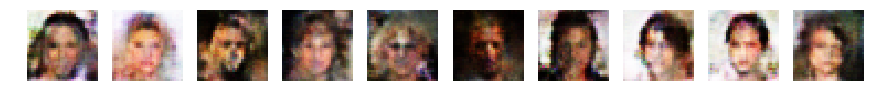

2 700 1583 7.050919532775879


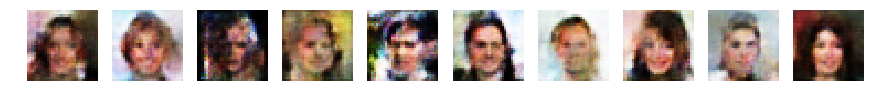

2 1400 1583 9.062908172607422


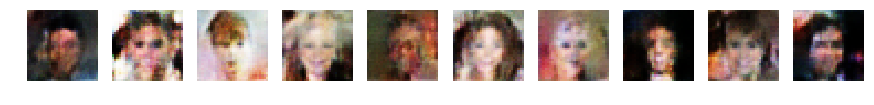

3 0 1583 6.877035617828369


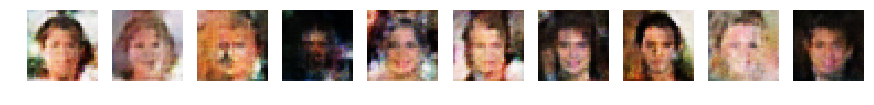

3 700 1583 7.986405372619629


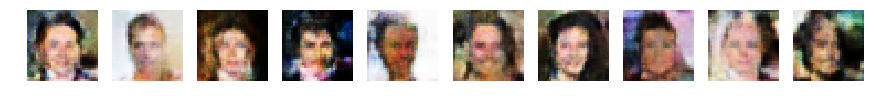

3 1400 1583 10.193347930908203


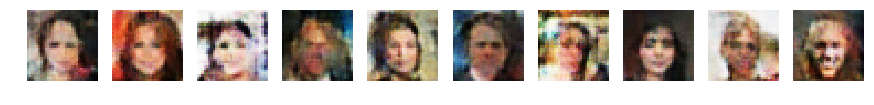

4 0 1583 7.2884674072265625


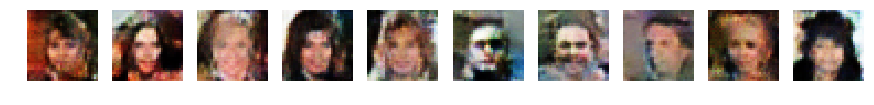

4 700 1583 6.937892913818359


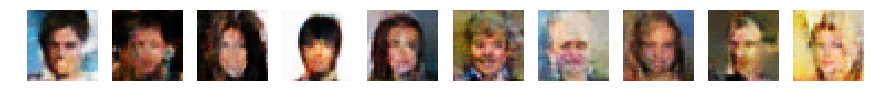

4 1400 1583 7.4137091636657715


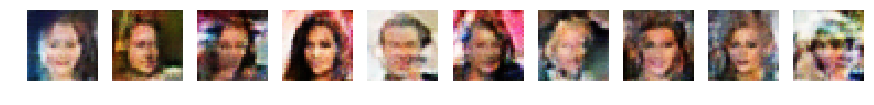

5 0 1583 6.533334732055664


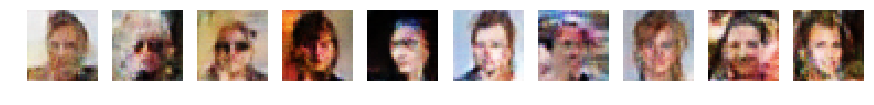

5 700 1583 5.193155765533447


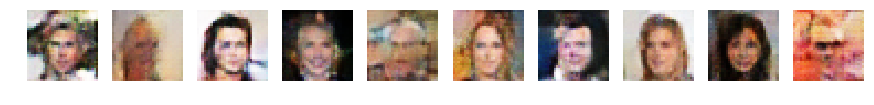

5 1400 1583 5.446792125701904


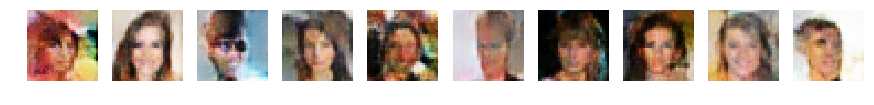

6 0 1583 4.586384296417236


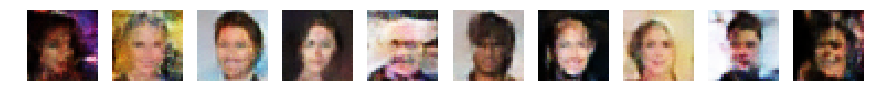

6 700 1583 8.015811920166016


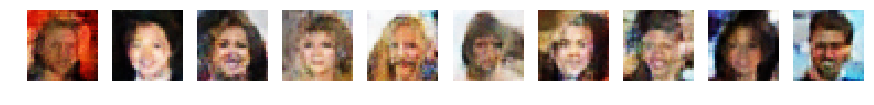

6 1400 1583 2.529151201248169


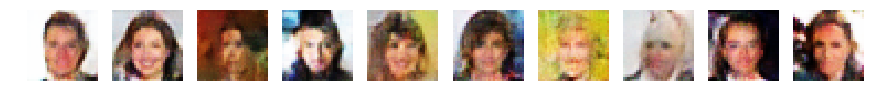

7 0 1583 5.088477611541748


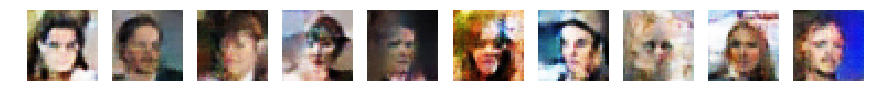

7 700 1583 5.213472843170166


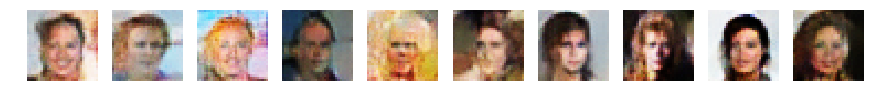

7 1400 1583 6.636464595794678


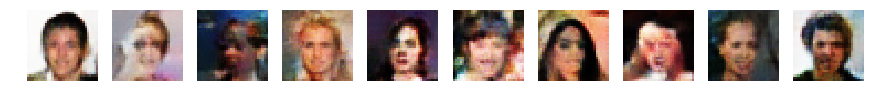

8 0 1583 4.8061394691467285


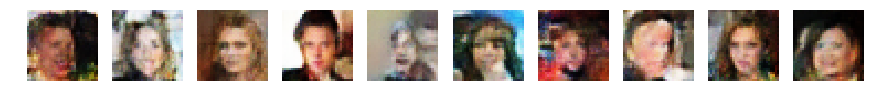

8 700 1583 4.295200824737549


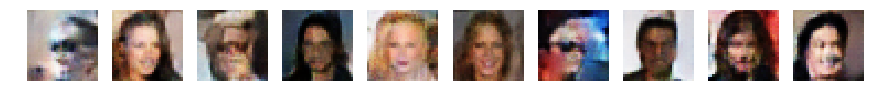

8 1400 1583 3.314628839492798


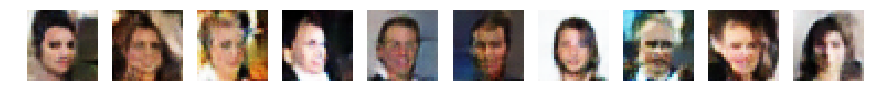

9 0 1583 5.237847805023193


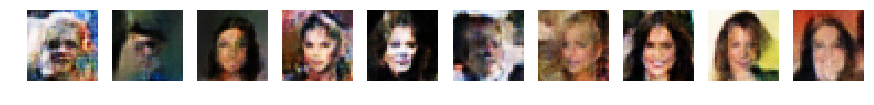

9 700 1583 5.573035717010498


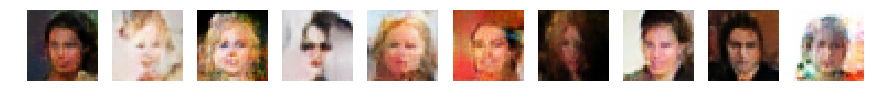

9 1400 1583 6.53043270111084


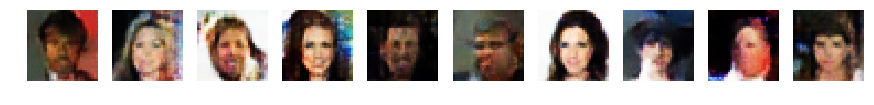

10 0 1583 8.048080444335938


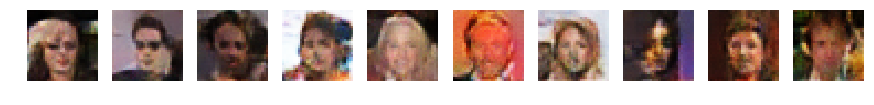

10 700 1583 3.42635440826416


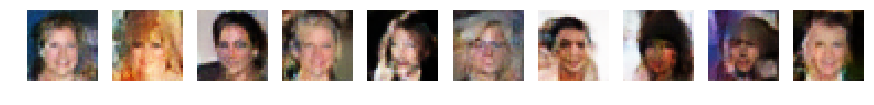

10 1400 1583 5.294424533843994


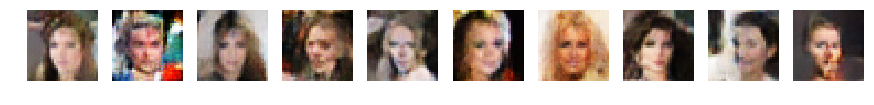

11 0 1583 4.783135414123535


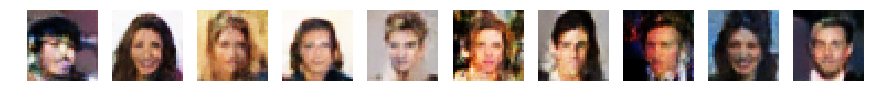

11 700 1583 6.058938026428223


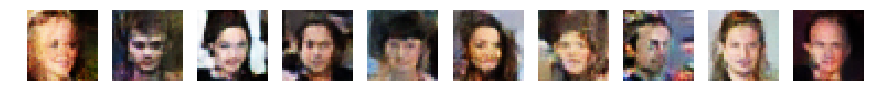

11 1400 1583 6.556082725524902


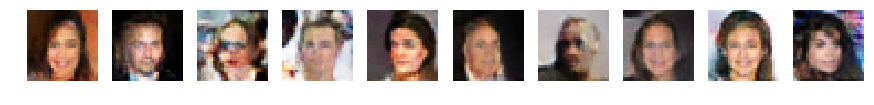

12 0 1583 3.2901763916015625


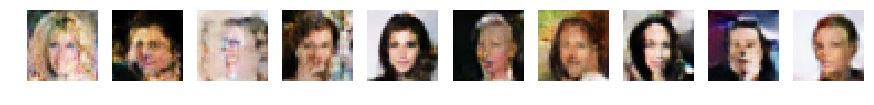

12 700 1583 7.712117671966553


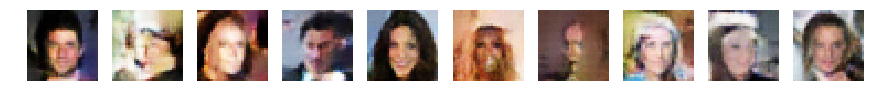

12 1400 1583 7.884117603302002


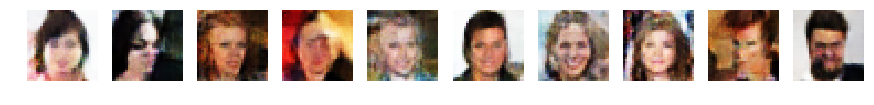

13 0 1583 5.115506649017334


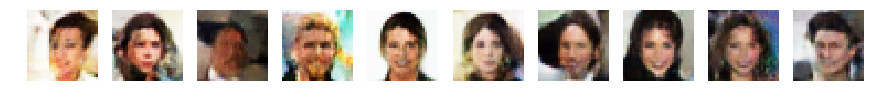

13 700 1583 4.652760028839111


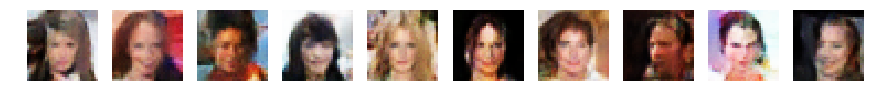

13 1400 1583 7.200592517852783


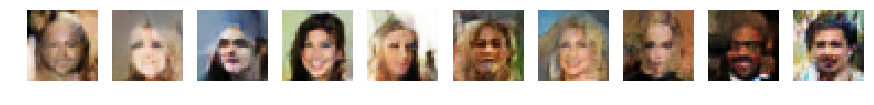

14 0 1583 5.970262050628662


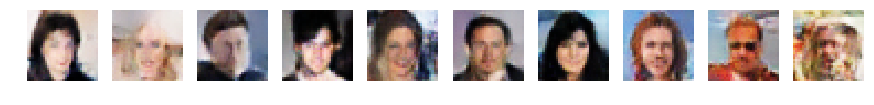

14 700 1583 6.532891750335693


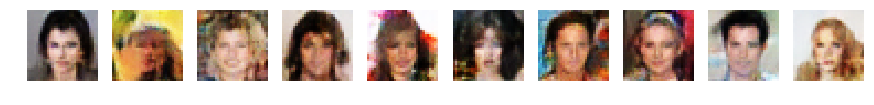

14 1400 1583 5.233650207519531


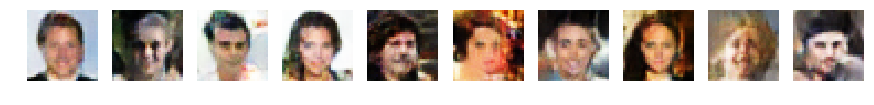

15 0 1583 6.527991771697998


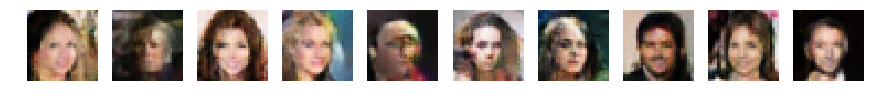

15 700 1583 7.483516693115234


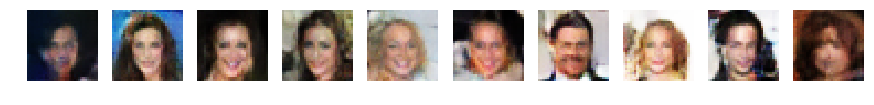

15 1400 1583 10.20719051361084


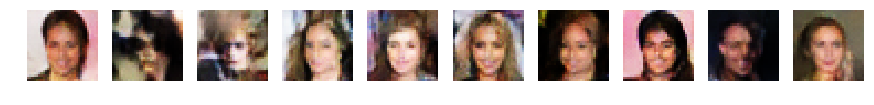

16 0 1583 5.166875839233398


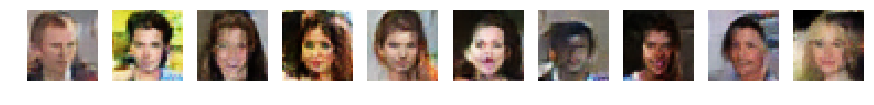

16 700 1583 6.367485523223877


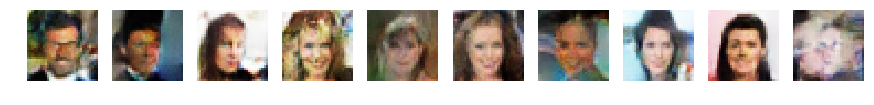

16 1400 1583 6.533306121826172


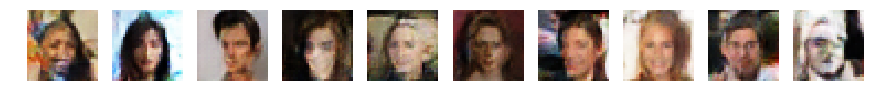

17 0 1583 7.399277210235596


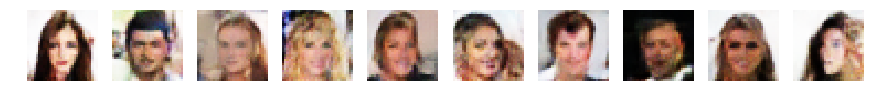

17 700 1583 7.482849597930908


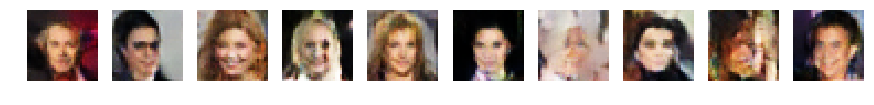

17 1400 1583 6.73539400100708


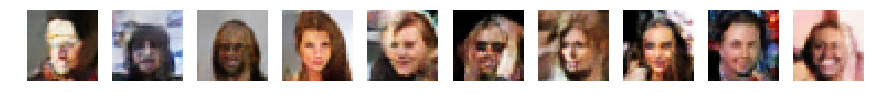

18 0 1583 7.453084468841553


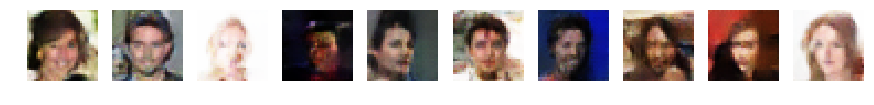

18 700 1583 5.783350944519043


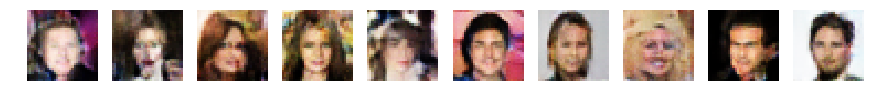

18 1400 1583 5.013589859008789


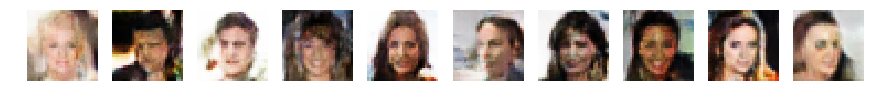

19 0 1583 6.161648750305176


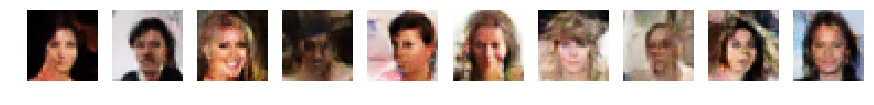

19 700 1583 7.664737224578857


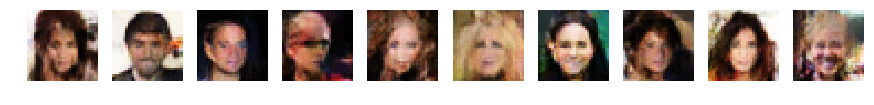

19 1400 1583 4.48553466796875


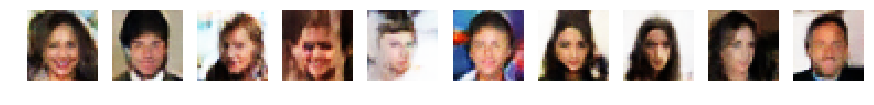

In [3]:
netG = GeneratorNet(input_nfilters=options.n_filters, generator_nfilters=64, 
                    image_size=options.image_size, n_colors=3)
netD = DiscriminatorNet(discriminator_nfilters=32, image_size=options.image_size, n_colors=3)

criterion = nn.BCELoss()

noise = torch.FloatTensor(options.batch_size, options.n_filters, 1, 1)

if options.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    noise = noise.cuda()

# setup optimizer.
# Yup, just added minus to learning rate - and that's where you get adeversarial training :)
optimizerD = optim.Adam(netD.parameters(), lr=-1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=+1e-4, betas=(0.5, 0.999))

for epoch in range(20):
    for i, (real_cpu, _) in enumerate(dataloader):
        netD.zero_grad()
        netG.zero_grad()

        # get real batch
        if options.cuda:
            real_cpu = real_cpu.cuda()
        real = Variable(real_cpu)

        # generate fake
        noise.normal_(0, 1)
        fake = netG(Variable(noise))

        # joint to have common batch-norm transform
        outputs = netD(torch.cat([real, fake], dim=0))
        output_real = outputs[:real.size(0)]
        output_fake = outputs[real.size(0):]

        MMD = torch.norm(output_fake.mean(dim=0) - output_real.mean(dim=0))
        MMD.backward()

        optimizerD.step()
        optimizerG.step()

        if i % 700 == 0:
            print(epoch, i, len(dataloader), MMD.data[0])
            show_images(fake.data)